In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
import nclcmaps as nclc
from utils import add_days_to_date

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


In [3]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [4]:
arname = 'feb1998'
# import configuration file for case study choice
yaml_doc = '../data/config_files/ar_casestudy.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ar_dict = config[arname]

year = ar_dict['year']
month = ar_dict['month']
start_date = ar_dict['start_date']
end_date = add_days_to_date(ar_dict['end_date'], 1)
print(start_date, end_date)

# Select lat/lon grid
lonmin = 20
lonmax = 95
latmin = 10
latmax = 60

1998-02-12 1998-02-16


In [5]:
## Get terrain data for plotting
wrf_filenames = ar_dict['wrf_files2'] 
wrfin = nc.Dataset(wrf_filenames[0])
terrain = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

In [6]:
## ivt data
rename_dict_ivt = {'p71.162': 'ivte', 
                   'p72.162': 'ivtn',
                   'latitude': 'lat',
                   'longitude': 'lon'}

filepath = path_to_data + 'ERA5/ivt/6hr/era5_hma_05dg_6hr_ivt_' + str(year) + '.nc'
ds = xr.open_dataset(filepath)
ds = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=slice(start_date, end_date))
ds = ds.rename(rename_dict_ivt)

ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivte**2 + ds.ivtn**2))

In [7]:
## upper level data
rename_dict_upper = {'z': 'H', 
                     'u': 'U250', 
                     'v':'V250', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

filepath = path_to_data + 'ERA5/huvq/6hr/era5_hma_05dg_6hr_huvq_' + str(year) + '.nc'
ds2 = xr.open_dataset(filepath)
ds2 = ds2.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=slice(start_date, end_date), level=250.)
ds2 = ds2.rename(rename_dict_upper)
ds2 = ds2.assign(H=lambda ds2: ds2.H/(9.80665)) # convert to geopotential height (m)

In [8]:
rename_dict_prec = {'mtpr': 'prec', 
                    'latitude': 'lat',
                    'longitude': 'lon'}

filepath = path_to_data + 'ERA5/prec/6hr/era5_hma_025dg_6hr_prec_' + str(year) + '.nc'
ds3 = xr.open_dataset(filepath)
ds3 = ds3.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=slice(start_date, end_date))
ds3 = ds3.rename(rename_dict_prec)
ds3 = ds3.assign(prec=lambda ds3: ds3.prec*21600) # convert to mm per 6-hour

In [9]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# extent of maps
ext = [lonmin,lonmax,latmin,latmax]
ext2 = [60, 105, 20, latmax]

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+10,10)

# get correct grid size for figure
nplots = len(ds3.time)
ncols = 4
rem = nplots % ncols # check for remainder
nrows = nplots // ncols # integer division

# hack for tick labels to only label far right and bottom grids
share_bottom = [False]*(ncols)*(nrows-1) + [True]*ncols
share_right = ([False]*(ncols-1) + [True])*nrows

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

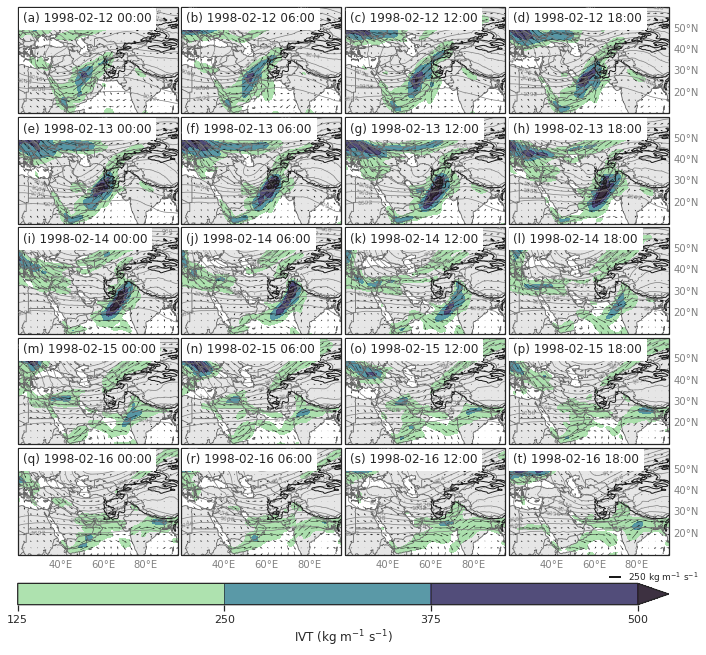

In [10]:
filepath = path_to_figs + arname + '_era5_IVT_6hrly.png'

# Create figure
fig = plt.figure(figsize=(25., (2*nrows)+1))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='5%',label_mode='',
                direction='row')

if rem > 0:
    axgr = axgr[:-(rem)]
    # hide extra grids if uneven number of time steps
    for i in range(rem):
        axgr[-(i+1)].remove()
else:
    axgr = axgr

for k, ax in enumerate(axgr):
    # lat/lon arrays
    lats = ds.lat.values
    lons = ds.lon.values    
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k])
    
    # Contour Filled
        
    # IVT (filled contour)
    uvec = ds.ivte.isel(time=k).values
    vvec = ds.ivtn.isel(time=k).values
    ivt = ds.ivt.isel(time=k).values
    ivt_sm = gaussian_filter(ivt, sigma=1.5)
    cflevs = np.arange(125, 510, 125)
    cf = ax.contourf(lons, lats, ivt_sm, transform=datacrs,
                     levels=cflevs, cmap=cmo.deep, alpha=0.9, extend='max') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=50, units='xy')
    
    # Contour Lines
    # 250-hPa Heights
    hgts = ds2.H.isel(time=k).values/10. #convert to dekameters
    clevs = np.arange(840, 1280, 12)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7, linestyles='solid')
    kw_clabels = {'fontsize': 6, 'inline': True, 'inline_spacing': 10, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # Contour Lines (terrain)
    terclevs=np.array([1000])
    terlons = terrain.XLONG.values
    terlats = terrain.XLAT.values
    cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # subtitles
    date = ds.time[k].values
    
    t = pd.to_datetime(str(date)) 
    timestring = t.strftime('%Y-%m-%d %H:00')
    ttl = "({0}) ".format(letter_lst[k]) + timestring
#     ax.set_title(timestring, loc='left',fontsize=13)
    # ax.annotate(timestring, (5, 90), xycoords='axes points', fontsize=12.,
    #                 backgroundcolor='white')
    
    ax.text(0.03, 0.9525, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

# quiver key
qk = ax.quiverkey(Q, 0.7, -0.21, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 9.0})
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


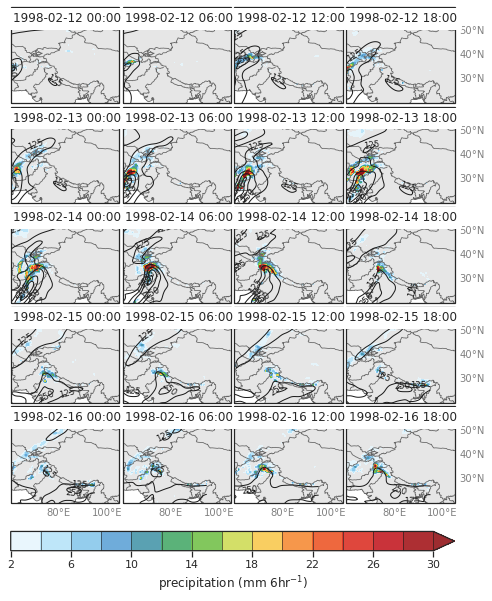

In [11]:
filepath = path_to_figs + month + str(year) + '_era5_prec_6hrly.png'

# Create figure
fig = plt.figure(figsize=(16, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='5%',label_mode='',
                direction='row')

if rem > 0:
    axgr = axgr[:-(rem)]
    # hide extra grids if uneven number of time steps
    for i in range(rem):
        axgr[-(i+1)].remove()
else:
    axgr = axgr

for k, ax in enumerate(axgr):  
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy, left_lats=False, right_lats=share_right[k], 
                      bottom_lons=share_bottom[k], mask_ocean=False)
    
    
    # Contour Filled (prec)
    lats = ds3.lat.values
    lons = ds3.lon.values  
    prec = ds3.prec.isel(time=k).values
    cflevs = np.arange(2, 32, 2)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
    # Contour Lines (IVT)
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.ivt.isel(time=k).values
    ivt_sm = gaussian_filter(ivt, sigma=2.0)
    clevs = np.arange(125, 510, 125)
    cs = ax.contour(lons, lats, ivt_sm, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.0)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 
    
    
    # subtitles
    date = ds.time[k].values
    t = pd.to_datetime(str(date)) 
    timestring = t.strftime('%Y-%m-%d %H:00')
#     ax.set_title(timestring, loc='left',fontsize=13)
    # ax.annotate(timestring, (5, 143), xycoords='axes points', fontsize=12.,
    #                     backgroundcolor='white', zorder=101)
    ax.text(0.025, 0.9525, timestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('precipitation (mm 6hr$^{-1}$)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
